In [1]:
# Standard libraries
import os
import sys

#Third party libraries
import rasterio.plot
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(legacy='1.25')
import geopandas
import shapely

# Local applications
package_dir = os.path.dirname(os.getcwd())
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
from hpr_detection_toolkit import utils
from hpr_detection_toolkit.line_detection import LineSegmentDetector
from hpr_detection_toolkit.hpr_detection import HprDitchDetector

# Setting up
First we define the coordinate reference system in which we want to work in. 

In [2]:
target_crs = "EPSG:31370"

In this example, we will test a single permanent grassland landplot extracted from the 7 year agriculture usage map (Lbgb2016-2020) located on KB20 of the VITO predicted logits raster map. When loading in these data sets, we will check if the data set is already in the correct crs or needs reprojection.

We load the necessary data using the helper function in the utils module of the package.
1. the landplot represented by a polygon in a geopandas.DataFrame object
2. the VITO raster data wrapped in a rasterio.DataReader object

> **Adjust the filepath for your own local set-up!**

In [3]:
landplot = utils.open_vector_data('Data/Example_Landplot.gpkg', layer='lbgbrprc23')
VITO_map = utils.open_raster_data('E:/Stage INBO/Data/VITO_microrelief/KB20_predicted_logits.tif', target_crs)

Vector data in Data/Example_Landplot.gpkg in EPSG:31370, no reprojection.
Raster data in E:/Stage INBO/Data/VITO_microrelief/KB20_predicted_logits.tif in EPSG:31370, no reprojection.


Because the categorisation of the grassland only depends on the microrelief within the landplot itself, we clip the raster data using the boundaries of the landplot.

----------------------------------------
METADATA - /vsimem/18aa2d70-6601-4371-85e2-63b51ab952a1/18aa2d70-6601-4371-85e2-63b51ab952a1.tif
----------------------------------------
Image bands:	1
Image shape:	(771,981)
CRS:		EPSG:31370
Bounds:		left-right (38752.25, 38945.0)
		top-bottom (184929.75, 184684.5)

Geotransform:
| 0.25, 0.00, 38752.25|
| 0.00,-0.25, 184929.75|
| 0.00, 0.00, 1.00|
----------------------------------------


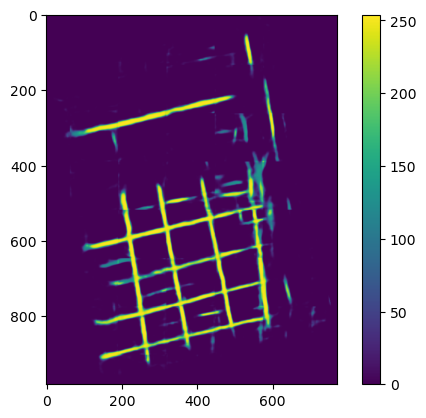

In [4]:
raster = utils.clip_raster(VITO_map, landplot.geometry.iloc[0].geoms)
utils.print_raster_metadata(raster)
plt.imshow(raster.read(1))
plt.colorbar()

# Processing the grassland
The categorisation of the grassland is based on the presence of ditches in the landplot. When a buffer zone around the ditches of 30 m covers 70% of the landplot's area, the grassland can be categorised as HPR. The `HprDitchDetector` class from this package performs the necessary processing step to detect the ditches and determine the area fraction of the buffer zone.

To do so, the `HprDitchDetector` uses some default configuration, which are stored in a yaml file. Nevertheless, the user can overwrite the default settings by handing the class a configuration file containing the setting to be overwritten (dict format).

To detect the ditches, the `HprDitchDetector` relies on a `LineSegmentDetector` object. This also uses default configuration saved in the samen yaml file, which can be overwritten in a similar manner.

In [5]:
lsd = LineSegmentDetector()
user_config = {'buffer_zone': {
                    'distance': 15.},
               'filter_background': {
                    'threshold_value': .5*np.max(raster.read(1))}
              }
hpr_detector = HprDitchDetector(VITO_map, lsd, config=user_config)

Once the `HprDitchDetector` has been initialised, it can be used to process a landplot (geodataframe with one row holding a polygon).

In [6]:
hpr_detector.process(landplot)

# The result
Once processed you can request the line segments in the ditches, the polygon of the buffer zone, and the fraction of the landplot that is covered by this buffer zone.

In [7]:
ditches = hpr_detector.get_ditches(multilinestring=False)
buffer_zone = hpr_detector.get_buffer_zone()

print(f'The buffer zone around the detected dithes covers {hpr_detector.get_hpr_fraction()*100:.0f}% of the landplot')
print(f'> the grassland CAN{'NOT' if hpr_detector.get_hpr_fraction() < .7 else ''} be categorised as hpr')

The buffer zone around the detected dithes covers 70% of the landplot
> the grassland CAN be categorised as hpr


---

We will save both the ditches and the buffer zone in different layers of a geopackage:
1. `single-line features` holding all line segments as seperate LineString objects
2. `multi-line features` holding all line segments in one MultiLineString object
3. `buffer features`holding the complete buffer zone as one Polygon or MultiPolygon

In [8]:
output_filename = 'DetectionMicrorelief_ExampleGrassland.gpkg'
if os.path.exists(output_filename):
    os.remove(output_filename)
ditches.to_file(output_filename, driver="GPKG", mode='a', layer='single-line features')
multiline = geopandas.GeoDataFrame(geometry=[shapely.MultiLineString(ditches['geometry'].tolist())], crs=target_crs)
multiline.to_file(output_filename, driver="GPKG", mode='a', layer='multi-line features')
buffer_zone.to_file(output_filename, driver='GPKG', mode='a', layer='buffer features')

---

Finally, we plot the detected ditches and buffer zone for visual inspection

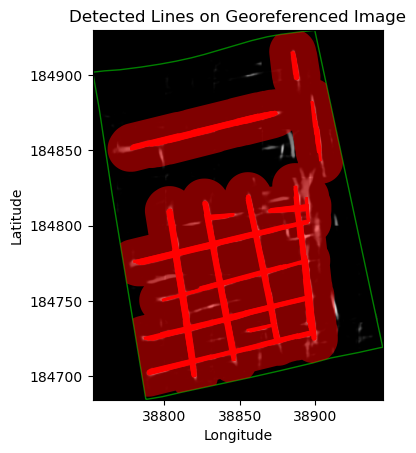

In [9]:
fig, ax = plt.subplots(1, 1) # Correct way to specify CRS

# Display the raster image
rasterio.plot.show(raster, ax=ax, cmap='gray')

# Plot the detected lines
landplot.plot(ax=ax, edgecolor='green', label='Perceel',facecolor='none')
buffer_zone.plot(ax=ax, color='red', alpha=0.5, label='30m Buffer')
ditches.plot(ax=ax, color='red', linewidth=2, label='Grachtjes')

ax.set_title("Detected Lines on Georeferenced Image")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()